In [ ]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Replace the path with the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/MURA-v1.1.zip'

# Replace with the directory where you want to unzip the folder
unzip_dir = '/content/MURA-v1.1'

# Create target directory if it doesn't exist
if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import shutil
import os

# Define the path to the inner folder and the outer folder
inner_folder = '/content/MURA-v1.1/MURA-v1.1'
outer_folder = '/content/MURA-v1.1'

# List all files and folders in the inner folder
for item in os.listdir(inner_folder):
    inner_item_path = os.path.join(inner_folder, item)
    outer_item_path = os.path.join(outer_folder, item)

    # Move each file and folder to the outer folder
    shutil.move(inner_item_path, outer_item_path)

# Optionally, remove the now-empty inner folder
os.rmdir(inner_folder)


In [ ]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [ ]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [ ]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [ ]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [ ]:
df_train_images_paths = df_train_images_paths[~df_train_images_paths['category'].isin(['XR_FOREARM', 'XR_HUMERUS'])]


In [ ]:
df_valid_data_paths = df_valid_data_paths[~df_valid_data_paths['category'].isin(['XR_FOREARM', 'XR_HUMERUS'])]


In [ ]:
print(df_train_images_paths['category'].unique())


['XR_SHOULDER' 'XR_FINGER' 'XR_ELBOW' 'XR_WRIST' 'XR_HAND']


In [ ]:
print(df_valid_data_paths['category'].unique())


['XR_WRIST' 'XR_HAND' 'XR_SHOULDER' 'XR_ELBOW' 'XR_FINGER']


In [ ]:
unique_categories = df_train_images_paths["category"].unique()
replace_dict = {category: idx for idx, category in enumerate(unique_categories)}
df_train_images_paths["category"].replace(replace_dict, inplace=True)


In [ ]:
unique_categories = df_valid_data_paths["category"].unique()
replace_dict = {category: idx for idx, category in enumerate(unique_categories)}
df_valid_data_paths["category"].replace(replace_dict, inplace=True)


In [ ]:
print(df_train_images_paths['category'].unique())


[0 1 2 3 4]


In [ ]:
df_train_images_paths = df_train_images_paths.reset_index(drop=True)

In [ ]:
df_valid_data_paths = df_valid_data_paths.reset_index(drop=True)

In [ ]:
!pip install scikit-image

In [ ]:
from skimage.feature import hog
from skimage.feature import canny
from skimage.filters import prewitt
from skimage.filters import gabor
from skimage.filters import sobel
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage.filters import hessian
from skimage.filters import median
from skimage import exposure
import random

In [ ]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')

        # Convert PIL Image to numpy array
        image_np = np.array(image)

        image_gray = rgb2gray(image_np)

        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)


        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)


        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)

        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)

        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))

        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)

        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        image = image.to(self.device)

        label = torch.tensor(label).to(self.device)

        return image, label


In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 12
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomGrayscale(p=0.5),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])
val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = MuraDataset(df_train_images_paths["image_path"], df_train_images_paths["category"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["category"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



Feature batch shape: torch.Size([12, 3, 224, 224])
Labels batch shape: torch.Size([12])


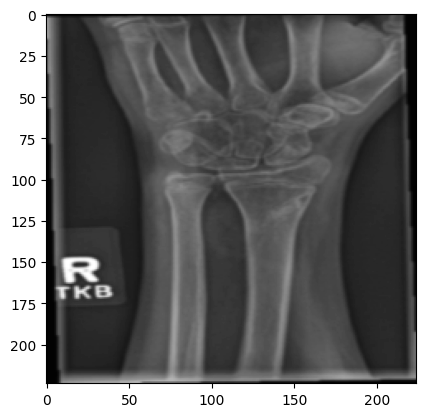

category: 0


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(valid_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"category: {label}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.0 MB/s eta 0:00:00


In [ ]:
from transformers import SwinForImageClassification
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

In [ ]:
model.classifier = nn.Linear(in_features=768, out_features=5)
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [ ]:
model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


        _, predicted = logits.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 200 batches
        if (batch_idx + 1) % 200 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


Epoch [1/1], Batch [200/2810], Batch Loss: 0.0382, Batch Accuracy: 96.29%
Epoch [1/1], Batch [400/2810], Batch Loss: 0.0174, Batch Accuracy: 96.58%
Epoch [1/1], Batch [600/2810], Batch Loss: 0.2074, Batch Accuracy: 96.50%
Epoch [1/1], Batch [800/2810], Batch Loss: 0.0990, Batch Accuracy: 96.57%
Epoch [1/1], Batch [1000/2810], Batch Loss: 0.0069, Batch Accuracy: 96.73%
Epoch [1/1], Batch [1200/2810], Batch Loss: 0.1766, Batch Accuracy: 96.81%
Epoch [1/1], Batch [1400/2810], Batch Loss: 0.0055, Batch Accuracy: 96.95%
Epoch [1/1], Batch [1600/2810], Batch Loss: 0.0102, Batch Accuracy: 97.04%
Epoch [1/1], Batch [1800/2810], Batch Loss: 0.0754, Batch Accuracy: 97.08%
Epoch [1/1], Batch [2000/2810], Batch Loss: 0.0245, Batch Accuracy: 97.15%
Epoch [1/1], Batch [2200/2810], Batch Loss: 0.0203, Batch Accuracy: 97.24%
Epoch [1/1], Batch [2400/2810], Batch Loss: 0.0084, Batch Accuracy: 97.32%
Epoch [1/1], Batch [2600/2810], Batch Loss: 0.0030, Batch Accuracy: 97.35%
Epoch [1/1], Batch [2800/2810

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch the model to evaluation mode
model.eval()

# Initialize lists to store all true labels and all predictions
all_labels = []
all_predictions = []

# Disabling gradient calculation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        logits = outputs.logits

        # Get predictions
        _, predicted = logits.max(1)

        # Store predictions and true labels for later calculation of metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print status for every 50 batches (or another number if you prefer)
        if (batch_idx + 1) % 100 == 0:
            print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")


# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions,average='weighted')  # Using weighted average if you have class imbalance
recall = recall_score(all_labels, all_predictions,average='weighted')  # Using weighted average if you have class imbalance
f1 = f1_score(all_labels, all_predictions,average='weighted')  # Using weighted average if you have class imbalance


print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")



Test Batch [100/218] Processed
Test Batch [200/218] Processed
Test Accuracy: 0.0115
Test Precision: 0.0109
Test Recall: 0.0115
Test F1-Score: 0.0112


In [ ]:
import torch
save_path = '/content/drive/MyDrive/SWIN_category_modelv2.pth'
torch.save(model,save_path)

